### Attribute Description:
Attribute | Description
----------|-------------
`Invoice No` | Invoice ID, encoded as Label
`StockCode` | Unique code per stock, encoded as Label
`Description` | The Description, encoded as Label
`Quantity` | Quantity purchased
`InvoiceDate` | Date of purchase
`UnitPrice` | The target value, price of every product
`CustomerID` | Unique Identifier for every country
`Country` | Country of sales, encoded as Label

### Target
`UnitPrice` is the target.

### Performance Measure
RMSE (Root Mean Square Error)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Initial Data Analysis

In [2]:
data = pd.read_csv("data/Train.csv")

In [67]:
test = pd.read_csv("data/Test.csv")

In [92]:
# test.Quantity.describe()
test[test.Quantity<0].shape[0]/test

2738

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


In [20]:
print("Shape of:")
print("-"*10)
print("\t Training data:", data.shape)
print("\t Test data:", test.shape)

Shape of:
----------
	 Training data: (284780, 8)
	 Test data: (122049, 7)


### Drop duplicates

In [9]:
print(f"There are {data[data.duplicated(keep=False)].shape[0]} duplicates in training data")

There are 5093 duplicates in training data


In [12]:
data = data.drop_duplicates(ignore_index=True)

### Missing Value Check and Type casting

In [38]:
print("Number of Nulls in Training data:",
      data.isna().sum()\
      .sum())

Number of Nulls in Training data: 0


In [40]:
print("Number of Nulls in Test data:",
        test.isna().sum()\
        .sum())

Number of Nulls in Test data: 0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282159 entries, 0 to 282158
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    282159 non-null  int64  
 1   StockCode    282159 non-null  int64  
 2   Description  282159 non-null  int64  
 3   Quantity     282159 non-null  int64  
 4   InvoiceDate  282159 non-null  object 
 5   UnitPrice    282159 non-null  float64
 6   CustomerID   282159 non-null  float64
 7   Country      282159 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 17.2+ MB


In [30]:
### change dtypes to appropriate data types as applicable
categorical_cols = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

# convert to string
data[categorical_cols] = data.loc[:,categorical_cols].astype('object')
# convert to datetime
data['InvoiceDate'] = pd.to_datetime(data.loc[:,'InvoiceDate'])

In [47]:
# non_numeric_cols = []
data.describe()
# drop(columns=['year','month','day_of_week','hour','minutes','day_of_month']).describe()

,Quantity,UnitPrice
count,284780.000000,284780.000000
mean,12.028468,3.451216
std,295.111588,78.399541
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [48]:
data[['Quantity', 'UnitPrice']].corr()

,Quantity,UnitPrice
Quantity,1.000000,-0.000924
UnitPrice,-0.000924,1.000000


### Observations

- There were $5093$ duplicate records in training data taht have been dropped.
- No missing values have been found.
- Both `Quantity` and `UnitPrice` have outliers. The severity of which needs to be further analysed. Although we will be limited in our ability to deal with outliers in `UnitPrice` since it is the target.
- Minimum for `Quantity` is -80995 which is imposssible and also observe that maximum is 80995. It will be further analysed.

# Engineer Temporal Features from `InvoiceDate`

In [31]:
data['year'] = data.InvoiceDate.dt.year
data['month'] = data.InvoiceDate.dt.month
data['day'] = data.InvoiceDate.dt.dayofweek # Monday=0, Sunday=6
data['hour'] = data.InvoiceDate.dt.hour
data['minutes'] = data.InvoiceDate.dt.minute
data['day_of_month'] = data.InvoiceDate.dt.day

In [32]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,hour,minutes,day_of_month
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056,35,2011,5,4,16,54,6
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098,35,2011,5,2,7,35,11
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044,35,2011,11,6,13,20,20
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525,35,2011,11,1,12,7,22
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952,35,2011,5,4,9,0,6


## General Hypothesis

#### $Q$: Does every Invoice has only one Associated customer?
$A:$ Yes every Invoice has only one unique customer associated with it. As shown below:

In [61]:
# No of unique InvoiceID
print("Number of unique ")data.InvoiceNo.nunique()

20971

In [66]:
print("Number of Invoices with Number of unique customers !=1 :",
     (data.groupby('InvoiceNo')['CustomerID'].nunique() != 1).sum()
     )


Number of Invoices with Number of unique customers !=1 : 0


# UNivariate ANalysis of Variables

## `Quantity`
From above Initaial analysis wkt. there are some discrepencies in Quantity values. We will explore them in depth.

In [ ]:
# sns.histplot(data.Quantity)
sns.boxplot(data.Quantity)

In [40]:
print(f"Number records where quantity is zero: {data[data.Quantity==0].shape[0]}")

Number records where quantity is zero: 0


In [42]:
print(f"Number of records where quantity < zero: {data[data.Quantity<0].shape[0]}")

Number of records where quantity < zero: 6153


### Analysing `-ve` order Quantities
Possibilities are that the negative quantities are either
- mistakenly recorded as negative quantity or
- result of negative proration such as  return orders [(refer)](https://knowledgecenter.zuora.com/BB_Introducing_Z_Business/How_Do_I_._._./How_do_I_handle_a_negative_invoice%3F).

It has been noticed that negative quantities are present even in the test set, thus reducing the chances of it being being data entry error.

In [95]:
data['Quantity_pos'] = data.Quantity.apply(lambda x: 'POS' if x>=0 else 'NEG')
# data.groupby(Quantity)

In [100]:
# jitter added
data['log_UnitPrice'] = np.log(data.UnitPrice+ np.full_like(data.UnitPrice, fill_value=0.01))#np.ones_like(data.UnitPrice))

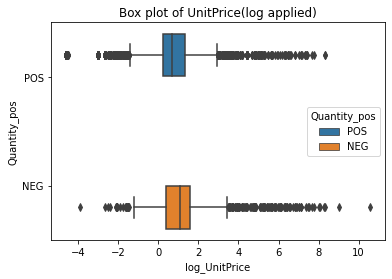

In [103]:
fig, ax = plt.subplots()
sns.boxplot(y='Quantity_pos', x='log_UnitPrice', data=data, hue='Quantity_pos')
# plt.xlim(right=5000)
plt.title("Box plot of UnitPrice(log applied)")
plt.show()

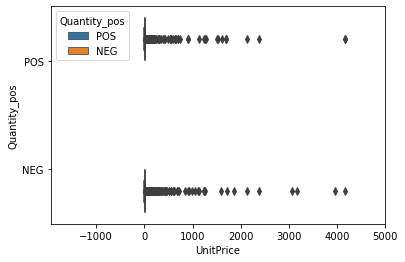

In [96]:
sns.boxplot(y='Quantity_pos', x='UnitPrice', data=data, hue='Quantity_pos')
plt.xlim(right=5000)
# data.UnitPrice.plot(kind='box', )
plt.show()

In [97]:
data.groupby('Quantity_pos')['UnitPrice'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
Quantity_pos,,,,,,,,
NEG,6153.0,20.599,521.433,0.01,1.45,2.95,4.95,38970.00
POS,276006.0,3.078,16.577,0.00,1.25,1.95,3.75,4161.06


In [77]:
data.groupby('Quantity_pos')['UnitPrice'].median()

Quantity_pos
N    2.95
Y    1.95
Name: UnitPrice, dtype: float64

In [26]:
data[data.Quantity < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
20,20652,3131,1576,-36,2011-07-26 10:15:00,1.06,12431,0
152,22083,2224,11,-1,2011-12-01 10:41:00,4.95,15993,35
157,19796,1521,2679,-6,2011-04-26 11:19:00,2.95,12705,14
186,21750,2166,1760,-100,2011-11-09 11:41:00,1.79,17511,35
196,21369,1014,2934,-17,2011-10-06 20:08:00,4.25,16839,35
...,...,...,...,...,...,...,...,...
281932,21879,2145,3746,-1,2011-11-18 09:44:00,2.10,17034,35
282031,21519,2294,1563,-1,2011-10-20 19:15:00,1.25,17169,35
282107,22148,2334,3664,-6,2011-12-06 14:57:00,3.75,15622,35
282120,20867,2658,826,-1,2011-08-22 15:00:00,3.25,16184,35


In [53]:
data[(data.CustomerID==17034) & (data.Description==3746)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,hour,minutes,day_of_month
281932,21879,2145,3746,-1,2011-11-18 09:44:00,2.1,17034,35,2011,11,4,9,44,18


In [43]:
data[(data.Description==1576)&(data.Quantity==-36)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,hour,minutes,day_of_month
20,20652,3131,1576,-36,2011-07-26 10:15:00,1.06,12431,0,2011,7,1,10,15,26


In [47]:
data[(data.Description==1576)&(data.Quantity==36)][0:10]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,hour,minutes,day_of_month
3969,739,3131,1576,36,2010-12-09 14:15:00,1.06,15311,35,2010,12,3,14,15,9
9186,13893,3131,1576,36,2011-10-12 12:58:00,1.06,14299,35,2011,10,2,12,58,12
10629,7509,3131,1576,36,2011-06-03 12:35:00,1.06,15189,35,2011,6,4,12,35,3
13225,3669,3131,1576,36,2011-03-08 11:39:00,1.06,13340,35,2011,3,1,11,39,8
34657,1704,3131,1576,36,2011-01-11 14:50:00,1.06,14733,35,2011,1,1,14,50,11
35549,2665,3131,1576,36,2011-02-08 14:06:00,1.06,15311,35,2011,2,1,14,6,8
36447,8908,3131,1576,36,2011-07-05 09:10:00,1.06,13408,35,2011,7,1,9,10,5
39455,3899,3131,1576,36,2011-03-14 12:58:00,1.06,14733,35,2011,3,0,12,58,14
44081,7702,3131,1576,36,2011-06-07 13:56:00,1.06,15311,35,2011,6,1,13,56,7
54299,8056,3131,1576,36,2011-06-14 13:15:00,1.06,13408,35,2011,6,1,13,15,14


In [45]:
data.Quantity.apply(lambda x: abs(x))

0          3
1          6
2          4
3          1
4         12
          ..
282154     6
282155    16
282156     4
282157    48
282158     2
Name: Quantity, Length: 282159, dtype: int64

In [ ]:
the quick brown fox jumps over the lazy dog.

\klflsa  /

## `Country`

In [18]:
print(f"There are data from {data.Country.nunique()} countries.")

There are data from 37 countries.


In [12]:
data.InvoiceNo.nunique()

20971

In [14]:
len(set(data.InvoiceNo.unique())\
    .intersection(set(test.InvoiceNo.unique()))
   )

16985

In [26]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

In [41]:
# data.rename(columns={'day':'day_of_week'}, inplace=True)


In [36]:
data.Description.nunique()

3819

In [59]:
data[data.InvoiceNo==6141].shape

(34, 14)

In [43]:
data[data.InvoiceNo==6141]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day_of_week,hour,minutes,day_of_month
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35,2011,5,4,16,54,6
20741,6141,1893,2683,3,2011-05-06 16:54:00,8.25,14056.0,35,2011,5,4,16,54,6
21318,6141,2106,1023,1,2011-05-06 16:54:00,7.95,14056.0,35,2011,5,4,16,54,6
35092,6141,1272,1988,2,2011-05-06 16:54:00,1.25,14056.0,35,2011,5,4,16,54,6
54221,6141,2626,1017,1,2011-05-06 16:54:00,7.95,14056.0,35,2011,5,4,16,54,6
63730,6141,2033,1762,1,2011-05-06 16:54:00,2.08,14056.0,35,2011,5,4,16,54,6
66639,6141,170,1953,1,2011-05-06 16:54:00,1.65,14056.0,35,2011,5,4,16,54,6
77522,6141,1894,2688,3,2011-05-06 16:54:00,8.25,14056.0,35,2011,5,4,16,54,6
77652,6141,2035,1761,1,2011-05-06 16:54:00,2.08,14056.0,35,2011,5,4,16,54,6
94976,6141,1473,2245,6,2011-05-06 16:54:00,0.29,14056.0,35,2011,5,4,16,54,6


# Basic Mean modelling

In [38]:
data.UnitPrice.mean()

3.46050097285573

In [ ]:
predicted = 